In [1]:
import pandas as pd
import numpy as np

In [2]:
def load(file):
    """Load the experiment data from a CSV file with converter metrics."""
    
    schema = {
        'num_threads': np.int64(),
        'num_jsons_converted': np.int64(),
        'num_json_bytes_converted': np.int64(),
        'num_ipc': np.int64(),
        'ipc_bytes': np.int64(),
        'num_buffers_converted': np.int64(),
        't_parse': np.float64(),
        't_resize': np.float64(),
        't_serialize': np.float64(),
        't_thread': np.float64(),
        't_enqueue': np.float64(),
        'status': np.int64()
    }
    
    df = pd.read_csv(file, dtype=schema)

    # Make sure there were no errors for converters.
    assert(df['status'].sum() == len(df.index))
        
    return df

In [3]:
def analyze(df):
    """Analyze the experiment data, deriving various metrics such as throughput."""
    # Calculate time spent within the thread as 'other'.
    df['t_other'] = df['t_thread'] - df[['t_parse', 't_resize', 't_serialize', 't_enqueue']].sum(axis=1)
    
    # Calculate throughput
    df['Throughput (in)'] = df['num_json_bytes_converted'] / df['t_thread']
    df['Throughput (out)'] = df['ipc_bytes'] / df['t_thread']
    
    df['Parse throughput (in)'] = df['num_json_bytes_converted'] / df['t_parse']
    
    return df

In [4]:
def summarize(df):
    """Summarize the data from all threads into one row."""
    
    # num_threads,num_jsons_converted,num_json_bytes_converted,num_ipc,ipc_bytes,
    # num_buffers_converted,t_parse,t_resize,t_serialize,t_thread,t_enqueue,status
    
    row = {'Threads': df['num_threads'].sum(),
             'JSONs': df['num_jsons_converted'].sum(), 
             'Bytes (in)': df['num_json_bytes_converted'].sum(), 
             'IPC messages': df['num_ipc'].sum(),
             'IPC bytes': df['ipc_bytes'].sum(),
             'Buffers converted': df['num_buffers_converted'].sum(), 
             # Take the mean of the time spent in threads:
             'Parse time': df['t_parse'].mean(),
             'Resize time': df['t_resize'].mean(), 
             'Serialize time': df['t_serialize'].mean(), 
             'Enqueue time': df['t_enqueue'].mean(), 
             'Other time': df['t_other'].mean(),
             'Thread time': df['t_thread'].mean(), 
             'Throughput (in)': df['Throughput (in)'].sum(),
             'Throughput (out)': df['Throughput (out)'].sum(),
             'Parse throughput (in)': df['Parse throughput (in)'].sum()}
              
    return row;

In [5]:
import glob

csv_files = []
for file in glob.glob("../experiments/data/battery/latency/threads/metrics/custom/*.csv"):
    csv_files.append(file)

records = []
for file in csv_files:
    records.append(summarize(analyze(load(file))))


df = pd.DataFrame.from_records(records)

display(df)

df.sort_values(by=['Threads', 'JSONs'], inplace=True)
df = df[df.JSONs == df.JSONs.max()]

df.set_index('Threads', inplace=True)

display(df)

,Threads,JSONs,Bytes (in),IPC messages,IPC bytes,Buffers converted,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Throughput (in),Throughput (out),Parse throughput (in)
0,30,1024,51072,960,257792,960,0.025506,0.000024,0.000973,0.000113,0.023122,0.049739,1.027156e+06,5.184646e+06,2.545184e+06
1,15,8388608,417314336,8640,573506816,480,0.211194,0.001942,0.020701,0.000197,0.051141,0.285176,1.463359e+09,2.011065e+09,1.986786e+09
2,16,16384,812128,512,1212928,512,0.014548,0.000018,0.000572,0.000098,0.010511,0.025748,3.154649e+07,4.711507e+07,6.099678e+07
3,6,131072,6482144,192,8899072,192,0.021277,0.000021,0.000640,0.000082,0.008584,0.030603,2.118126e+08,2.907888e+08,3.114457e+08
4,24,8192,402112,768,700416,768,0.021241,0.000021,0.000865,0.000104,0.019809,0.042040,9.565786e+06,1.666214e+07,2.245149e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,3,32768,1608992,96,2212352,96,0.010453,0.000021,0.000711,0.000088,0.004299,0.015571,1.033311e+08,1.420794e+08,1.541653e+08
507,13,1048576,52092864,1248,71593472,416,0.050011,0.000434,0.002824,0.000084,0.025311,0.078663,6.622337e+08,9.101365e+08,1.070137e+09
508,13,65536,3244000,416,4515584,416,0.013372,0.000018,0.000522,0.000083,0.010027,0.024021,1.350660e+08,1.880093e+08,2.689442e+08
509,22,16777216,834744832,16896,1147122176,704,0.278875,0.002869,0.031155,0.000217,0.074189,0.387305,2.155263e+09,2.961803e+09,3.089462e+09


,JSONs,Bytes (in),IPC messages,IPC bytes,Buffers converted,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Throughput (in),Throughput (out),Parse throughput (in)
Threads,,,,,,,,,,,,,,
1,16777216,834744832,16384,1147022592,32,2.959480,0.025487,0.633986,0.003692,0.020515,3.643160,2.291266e+08,3.148428e+08,2.820579e+08
2,16777216,834744832,16384,1147022592,64,1.881115,0.016765,0.326620,0.001508,0.163837,2.389845,3.492883e+08,4.799569e+08,4.439209e+08
3,16777216,834744832,16416,1147028992,96,1.074527,0.011569,0.151874,0.001100,0.065743,1.304813,6.397427e+08,8.790752e+08,7.769829e+08
4,16777216,834744832,16384,1147022592,128,0.914252,0.009314,0.124147,0.000855,0.108683,1.157253,7.213161e+08,9.911602e+08,9.133385e+08
5,16777216,834744832,16480,1147041280,160,0.675863,0.007540,0.083347,0.000726,0.017834,0.785310,1.062949e+09,1.460622e+09,1.235138e+09
6,16777216,834744832,16512,1147047424,192,0.623867,0.006362,0.072811,0.000620,0.113088,0.816747,1.022036e+09,1.404409e+09,1.344799e+09
7,16777216,834744832,16576,1147060992,224,0.559057,0.006160,0.065368,0.000477,0.191412,0.822473,1.014921e+09,1.394649e+09,1.509915e+09
8,16777216,834744832,16384,1147022592,256,0.497012,0.005395,0.056695,0.000325,0.160523,0.719951,1.159447e+09,1.593196e+09,1.689388e+09
9,16777216,834744832,16416,1147028992,288,0.419848,0.005041,0.054208,0.000251,0.111189,0.590537,1.413535e+09,1.942349e+09,2.002659e+09


In [6]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

2.694094745148582

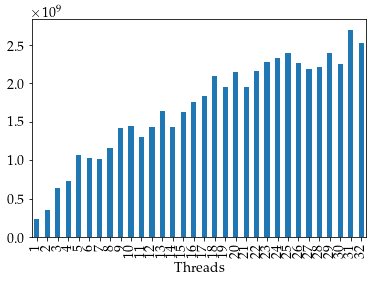

In [7]:
df['Throughput (in)'].plot.bar()
display(df['Throughput (in)'].max() * 1e-9)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


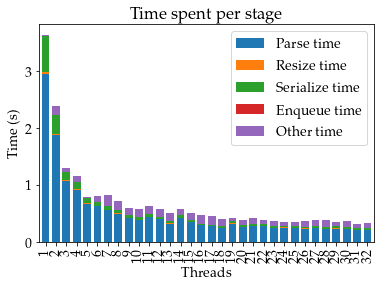

In [8]:
df_times = df[['Parse time', 'Resize time', 'Serialize time', 'Enqueue time', 'Other time']]
df_times.rename(columns={'Parse time': 'Parse', 
                         'Resize time': 'Resize', 
                         'Serialize time': 'Serialize', 
                         'Enqueue time': 'Enqueue', 
                         'Other time': 'Other'})
ax = df_times.plot.bar(stacked=True, 
                        width=0.75,
                        title='Time spent per stage',
                        ylabel='Time (s)')

In [9]:
from pywaffle import Waffle

wd = df_times.sum()

plt.figure(
    FigureClass=Waffle,
    rows=1,
    columns=100,
    values=wd,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
)

plt.tight_layout()

wd

Parse time        16.222328
Resize time        0.162403
Serialize time     2.320158
Enqueue time       0.015028
Other time         3.445452
dtype: float64